# Prepare the Data

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
equity = pd.read_excel('../data/industry_equity_data.xlsx',sheet_name='total returns')
equity.set_index('Date',inplace=True)
ff = pd.read_excel('../data/fama_french_data.xlsx',sheet_name='total returns')
ff.set_index('Unnamed: 0',inplace=True)

In [3]:
display(equity.head())
display(ff.head())

,AAPL,AMZN,GS,JPM,MSFT,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY
Date,,,,,,,,,,,,,,,
2000-01-31,0.009118,-0.151888,-0.025871,0.044493,-0.161671,-0.049787,-0.122281,0.008074,-0.029586,-0.081794,-0.061485,0.008819,-0.017768,-0.025291,-0.124246
2000-02-29,0.104820,0.066796,0.009550,-0.013168,-0.086845,-0.015227,-0.100469,-0.042334,-0.107046,-0.055173,0.105068,-0.117014,-0.121538,-0.065387,-0.055715
2000-03-31,0.184842,-0.027223,0.137838,0.094977,0.188811,0.096915,0.100893,0.124423,0.182624,0.139207,0.083893,0.037593,0.109237,0.089950,0.141516
2000-04-30,-0.086517,-0.176306,-0.112879,-0.168445,-0.343529,-0.035120,-0.033220,-0.014925,0.009659,0.014445,-0.091847,0.053019,0.065459,-0.011717,-0.020822
2000-05-31,-0.322922,-0.124575,-0.211126,0.035529,-0.103047,-0.015723,-0.031557,0.117424,0.022321,-0.004220,-0.103977,0.071329,-0.002194,-0.026804,-0.053980


,MKT,SMB,HML,UMD,RF
Unnamed: 0,,,,,
2000-01-31,-0.0433,0.0611,-0.0134,0.0227,0.0041
2000-02-29,0.0288,0.2162,-0.0851,0.1879,0.0043
2000-03-31,0.0567,-0.1635,0.0813,-0.0592,0.0047
2000-04-30,-0.0594,-0.0647,0.0787,-0.0811,0.0046
2000-05-31,-0.0392,-0.0583,0.0551,-0.0858,0.0050


In [4]:
equity = equity.subtract(ff['RF'],axis=0)
ff = ff[['MKT','SMB','HML','UMD']].subtract(ff['RF'],axis=0)

Note that the Fama-French factors are typically published as excess rerturns, meaning you would not need to subtract the risk-free rate.

I gave you a version of the data that was in total returns, so you need to subtract the risk-free rate.

But if you are ever accessing this data directly from the source, you'll find that the factors are already in excess returns.

# 2. Pricing Factor Stats

In [5]:
ff.mean() * 12

MKT    0.069661
SMB    0.030588
HML    0.020017
UMD    0.018089
dtype: float64

In [6]:
ff.corr()

,MKT,SMB,HML,UMD
MKT,1.000000,0.275907,0.006430,-0.384334
SMB,0.275907,1.000000,-0.175113,0.044277
HML,0.006430,-0.175113,1.000000,-0.223092
UMD,-0.384334,0.044277,-0.223092,1.000000


### Note:

The homework said to combine the assets and factors. 

SPY and MKT are over 98% correlated, so it makes sense to drop one of them to get better estimations. 

Below, set dropSPY to True if you want to estimate without SPY.

Though it would be bad practice to leave both included, it doesn't change the conclusions of this homework meaningfully.

In [7]:
dropSPY = False

assets = equity.join(ff,how='inner')
if dropSPY:
    assets = assets.drop(columns=['SPY'])

,AAPL,AMZN,GS,JPM,MSFT,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,MKT,SMB,HML,UMD
2000-01-31,0.005018,-0.155988,-0.029971,0.040393,-0.165771,-0.053887,-0.126381,0.003974,-0.033686,-0.085894,-0.065585,0.004719,-0.021868,-0.029391,-0.128346,-0.0474,0.0570,-0.0175,0.0186
2000-02-29,0.100520,0.062496,0.005250,-0.017468,-0.091145,-0.019527,-0.104769,-0.046634,-0.111346,-0.059473,0.100768,-0.121314,-0.125838,-0.069687,-0.060015,0.0245,0.2119,-0.0894,0.1836
2000-03-31,0.180142,-0.031923,0.133138,0.090277,0.184111,0.092215,0.096193,0.119723,0.177924,0.134507,0.079193,0.032893,0.104537,0.085250,0.136816,0.0520,-0.1682,0.0766,-0.0639
2000-04-30,-0.091117,-0.180906,-0.117479,-0.173045,-0.348129,-0.039720,-0.037820,-0.019525,0.005059,0.009845,-0.096447,0.048419,0.060859,-0.016317,-0.025422,-0.0640,-0.0693,0.0741,-0.0857
2000-05-31,-0.327922,-0.129575,-0.216126,0.030529,-0.108047,-0.020723,-0.036557,0.112424,0.017321,-0.009220,-0.108977,0.066329,-0.007194,-0.031804,-0.058980,-0.0442,-0.0633,0.0501,-0.0908


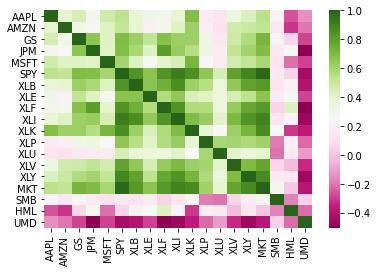

In [8]:
display(assets.head())
assets.corr()
sns.heatmap(assets.corr(), cmap="PiYG");

In [9]:
sig = assets.cov().to_numpy()
mu = assets.mean().to_numpy()

w_tan = (np.linalg.inv(sig) @ mu) / (np.ones(sig.shape[0]) @ np.linalg.inv(sig) @ mu)
weights = pd.DataFrame(w_tan.reshape(1,-1),columns = assets.columns,index=['MV Weights'])
display(weights)

,AAPL,AMZN,GS,JPM,MSFT,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,MKT,SMB,HML,UMD
MV Weights,0.22758,0.110723,0.029984,0.204299,0.136161,-2.042637,-0.037306,0.074824,-0.155377,0.430969,-0.16675,0.551779,0.211441,0.320702,0.286066,0.245527,0.189392,0.225909,0.156713


# 3. Testing Pricing Models with Alpha

In [10]:
def get_ols_metrics(regressors,targets,annualization=1):
    
    # ensure regressors and targets are pandas dataframes, as expected
    if not isinstance(regressors,pd.DataFrame):
        regressors = regressors.to_frame()
    if not isinstance(targets,pd.DataFrame):
        targets = targets.to_frame()

    # align the targets and regressors on the same dates
    df_aligned = targets.join(regressors,how='inner',lsuffix='y ')
    Y = df_aligned[targets.columns]
    X = df_aligned[regressors.columns]

    reg = pd.DataFrame(index=targets.columns)
    for col in Y.columns:
        y = Y[col]
        model = LinearRegression().fit(X,y)
        reg.loc[col,'alpha'] = model.intercept_ * annualization
        reg.loc[col,regressors.columns] = model.coef_
        reg.loc[col,'r-squared'] = model.score(X,y)

        # sklearn does not return the residuals, so we need to build them
        yfit = model.predict(X)
        residuals = y - yfit    
        reg.loc[col,'Info Ratio'] = (model.intercept_ / residuals.std()) * np.sqrt(annualization)

    return reg

### FF 4-factor model

In [11]:
regs_ff = get_ols_metrics(ff,equity)
display(regs_ff)
MAE = regs_ff['alpha'].abs().mean()
print(f'MAE of alphas is: {MAE:0.4f}')

,alpha,MKT,SMB,HML,UMD,r-squared,Info Ratio
AAPL,0.019093,1.352679,0.117844,-0.909914,0.001293,0.362616,0.207018
AMZN,0.016687,1.471444,-0.217903,-1.377709,-0.214873,0.377808,0.159143
GS,0.000269,1.440958,0.168063,0.184939,-0.009701,0.527299,0.004210
JPM,0.002239,1.132845,0.112535,0.608675,-0.375695,0.592023,0.040144
MSFT,0.005471,1.034522,-0.220485,-0.647813,-0.191773,0.418709,0.087048
SPY,0.000115,0.971085,-0.162798,0.017483,-0.027354,0.992445,0.030311
XLB,0.000594,1.092249,-0.158806,0.335655,-0.036423,0.728822,0.019154
XLE,-0.001481,1.054541,0.081496,0.579289,0.032801,0.513434,-0.029529
XLF,-0.001914,1.109366,-0.198247,0.721909,-0.125216,0.872799,-0.085772
XLI,0.000489,1.072654,-0.153311,0.286242,-0.073983,0.860577,0.024014


MAE of alphas is: 0.0040


### CAPM

In [12]:
regs_capm = get_ols_metrics(ff['MKT'],equity)
display(regs_capm)
MAE = regs_capm['alpha'].abs().mean()
print(f'MAE of alphas is: {MAE:0.4f}')

,alpha,MKT,r-squared,Info Ratio
AAPL,0.017770,1.371066,0.290220,0.182590
AMZN,0.013236,1.518602,0.268872,0.116446
GS,0.000769,1.479338,0.521054,0.011941
JPM,0.001849,1.326822,0.475502,0.029236
MSFT,0.003309,1.074215,0.349806,0.049781
SPY,-0.000197,0.951356,0.975867,-0.029061
XLB,0.000772,1.078879,0.676769,0.022798
XLE,-0.000281,1.058589,0.446376,-0.005258
XLF,-0.001524,1.129955,0.671848,-0.042504
XLI,0.000438,1.077024,0.804939,0.018216


MAE of alphas is: 0.0035


### Not using any pricing model

In [13]:
print(f'MAE of alphas is: {equity.mean().abs().mean():0.4f}')

MAE of alphas is: 0.0092


### Plot CAPM Fit

Plotting market beta against historic mean.

If CAPM fit, the scatter plot would (nearly) fit the line.

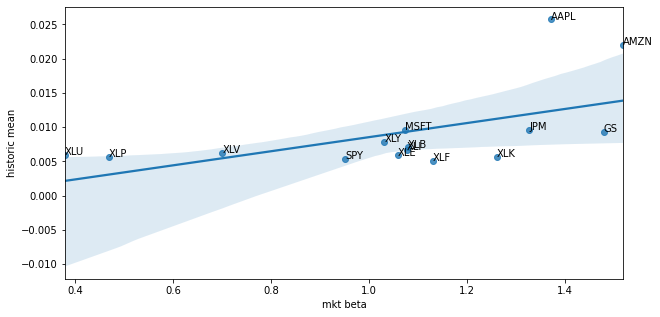

In [14]:
df = pd.DataFrame()
df['historic mean'] = equity.mean()
df['mkt beta'] = regs_capm[['MKT']]
df.reset_index(inplace=True)

ax = sns.regplot(x='mkt beta',y='historic mean',data=df)
df[['mkt beta','historic mean','index']].apply(lambda x: ax.text(*x),axis=1);
plt.gcf().set_size_inches(10,5)
plt.show()

# 4 Testing Pricing Models with Cross-Sectional Regressions

Regress $\overline{r}^i$ on $\hat{\boldsymbol{\beta}^i}$ from the previous time-series regressions.

In [15]:
X = regs_ff[['MKT','SMB','HML','UMD']]
y = equity.mean()
reg_cs = sm.OLS(y,sm.add_constant(X)).fit()
print(reg_cs.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.651
Model:                            OLS   Adj. R-squared:                  0.512
Method:                 Least Squares   F-statistic:                     4.667
Date:                Thu, 22 Jul 2021   Prob (F-statistic):             0.0220
Time:                        01:12:10   Log-Likelihood:                 63.351
No. Observations:                  15   AIC:                            -116.7
Df Residuals:                      10   BIC:                            -113.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0033      0.009      0.348      0.7

/Users/markhendricks/Projects/FINM/finm-quant-2021/venv/lib/python3.8/site-packages/scipy/stats/stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


We see that the R-squared is much less than 1, which means the betas do not fully explain expected returns.

The estimated intercept is near zero (and statistically insignficant,) so the issue is not that the expected returns are too high/low. Rather, it is that their variation does not correspond to variation in betas.

The estimated factor premium for HML is **negative**! And it is the most statistically significant factor. This throws doubt on the idea that the value factor is a source of premium--maybe we should be considering the growth factor!

### Plotting multifactor models

Given that there are multiple factors, we can't plot a single beta against the historic mean returns.

Rather, we can use the cross-sectional regression to fit the model-expected-return and plot that against the historic mean returns.

If the model fit, all the points would line up on the 45-degree line, (one-for-one.) 

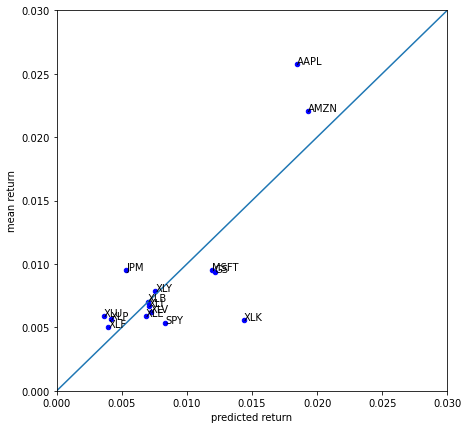

In [16]:
df = pd.DataFrame(columns=['mean return','predicted return'])
df['mean return'] = y
df['predicted return'] = reg_cs.predict(sm.add_constant(X))
df.reset_index(inplace=True)

ax = df.plot(x='predicted return',y='mean return',kind='scatter',color='blue',figsize=(7,7),xlim=(0,.03),ylim=(0,.03))
df[['predicted return','mean return','index']].apply(lambda x: ax.text(*x),axis=1);
y_line = np.arange(0, .04, .005)
x_line = y_line
ax.plot(y_line, x_line);

# Advanced (Optional) Insight:
## Weight on the Tangency portfolio

Above we looked at the tangency portfolio weights of the securities and factors.Are these weights "significant"? That is, are we sure that these weights are not just the 4 factors plus random noise?

It turns out that running OLS of y=1 on X = returns gives us the tangency weights! (They are a scaled version, but that doesn't matter.) Since this comes from regression betas, we also automatically get the t-stats and p-values! If the p-values are less than .05, then we say the regressor is statistically significant at the 5th percentile.

Let's see whether the factors are the only significant weights when included with the equities.

In [17]:
temp = sm.add_constant(assets)
X = temp.drop(columns=['const'])
y = temp[['const']]
mod = sm.OLS(y,X).fit()
pvals = mod.pvalues.to_frame()
pvals.columns = ['p-values']
pvals.T

,AAPL,AMZN,GS,JPM,MSFT,SPY,XLB,XLE,XLF,XLI,XLK,XLP,XLU,XLV,XLY,MKT,SMB,HML,UMD
p-values,0.000154,0.02068,0.740324,0.053987,0.105682,0.19702,0.834795,0.569607,0.618856,0.112502,0.616102,0.026371,0.15606,0.150572,0.211905,0.867597,0.513506,0.432208,0.227396


Not even close! In fact, the p-values for the four factors are all greater than .05, saying they're not significant in testing these equities. Instead, we find significance in teh weights for AAPL, AMZN, and XLP.

This is not a surprise. In fact, testing individual equities is very hard for these pricing models. Typically, they are used to price portfolios, and they are tested on portfolios.

### Do the extra 3 factors beyond the CAPM help much?

We could see whether the tangency portfolio is improved much by using the four factors (versus just using MKT.)

In [18]:
temp = sm.add_constant(ff)
X = temp[['MKT','SMB','HML','UMD']]
y = temp[['const']]

mod = sm.OLS(y,X).fit()
pvals = mod.pvalues.to_frame()
pvals.columns = ['p-values']
pvals.T

,MKT,SMB,HML,UMD
p-values,0.03293,0.50522,0.225421,0.147145


Nope--seems the only significant weight is that on MKT, which says that the other 3 factors are not expanding the frontier significantly--at least relative to just MKT.

So why are these factors used in pricing? They seem to help when we test them on many other returns. 

But hopefully this also helps illustrate why CAPM is still the baseline for many applications.